<h1><center>DSA 4212: Year 2021</center></h1>
<h3><center> Assignment 1 (Deadline: 28 March 2021 at 23:59) </center></h3>
<h3><center> To Be submitted on the lumiNUS )</center></h3>
<h2><center> Group Number: 32 </center></h2>
<h2><center> Group Member 1: Neo Zheng Jie Reo, A0183286W </center></h2>





The goal of this assignment is to explore 3 optimization methods that do NOT use any derivative information: 
1. **Particle swarm optimization**: https://en.wikipedia.org/wiki/Particle_swarm_optimization
2. **Simulated annealing**: https://en.wikipedia.org/wiki/Simulated_annealing
3. **Nelder-Mead**: https://en.wikipedia.org/wiki/Nelder–Mead_method

Start to read about these methods on wikipedia, as well as any other source [books / articles / blogs / etc...] that you seem appropriate. Describe as clearly as possible how these methods work and implement then from scratch. Explore the importance of the several tuning parameters. Discuss the advantage and drawbacks of these classes of methods and test them on some of the examples presented here: https://en.wikipedia.org/wiki/Test_functions_for_optimization


**Remark:**
1. acknowledge **all** the sources you are using to create this report. 
2. the clarity and readability of the report is important.
3. read widely and experiment.
4. It may be interesting/useful to create animations: the python package Celluloid is particularly easy to use [there are many others]

## Introduction

Gradient-based optimization methods are widely used in the field of machine learning today. With the backpropagation algorithm and use of computational graphs, gradient-based methods have become highly scalable and exclusively used to train deep networks which may contain billions of parameters. Gradients allow us to understand the local topology of the function that is being optimized but is not always available. Many problems are inherently discrete in nature and cannot be easily expressed as smooth and continuous functions. This report discusses three different optimization methods that do not require the use of gradients in the optimization procedure. In addition to understanding the mechanics and Python Implementation, they will also be evaluated on optimization test functions to evaluate their ability to find the speed, convergence rate and ability to find the global minimum



## Particle Swarm Optimisation


Particle Swarm Optimization (PSO) is a heuristic where the search space is populated by a large number of "particles" which are essentially initial guesses for where the global minimum might be. These particles are initialized with a uniformly distributed position and velocity over the entire search space. At each iteration, the velocity of the particles can be adjusted based on:
1. The optimal location which the particle has visited
2. The optimal location which has been visited by another particle in the swarm

By utilising the "wisdom of the crowd", the swarm should ideally converge towards the global optima of the function.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation
import random
import math
import seaborn as sns

from IPython.display import HTML

### Python Implementation

For the Python Implementation of the 3 algorithms, they wll have an `__init__` function where the hyperparameters of the algorithm will be set. Firstly, the algorithm will be instantiated as a Python Class and will have two primary methods which are the `__init__` method which will instantiate the hyperparameters and `optimize` method. This optimize method will take in 3 parameters which are:

1. `f` - (`function`) Function that is supposed to optimize
2. `lbs` - (`list`) Python List which contains the upper bounds for the search space
3. `ubs` - (`list`) Python List which contains the lower bounds for the search space

The lists lbs and ubs is necessary for this case to set the search space for the particles to be uniformly distributed. 


For the PSO algorithm, an additional Python Class `Particle` will be created as well. Since all the particles behave identically, having a `Particle` class will make the code a lot simpler. There are three important parameters which will determine the behavior of the algorithm. These parameters are:

1. Learning Rate - How much does the velocity of the particle affect its movement
2.  $w$ - How much the velocity of the particle at $t+1$ is influenced by the velocity at $t$
3. $\phi_g$ - How much is the velocity affected by the optima that the entire swarm has found
4. $\phi_p$ - How much the velocity of a particle is affected by optima that the particle has visited



In [2]:
class PSO():
    def __init__(self,n_iter = 100, l_r=0.5, w=0.3, phi_g=0.1,
                 phi_p=0.3, n_particles=100, verbose=False):
        self.l_r = l_r
        self.w = w
        self.phi_g = phi_g
        self.phi_p = phi_p
        self.n_particles = n_particles
        self.n_iter = n_iter
        self.verbose = verbose

    def optimize(self,f,lbs,ubs,log = False):
        assert len(lbs) == len(ubs),"Dimension of Search Space has to be the same size"
        positions = self.particle_init(f,lbs,ubs)
        if log: position_list = [positions.copy()]
        #print(position_list)
        for i in range(self.n_iter):
            if log: positions = []
            #Update Velocity of all the Particles
            for p in self.particles:
                p.update_velocity(self.swarm_argmin)
                pos = p.move()
                if p.get_min() < self.swarm_min:
                    self.swarm_argmin = p.get_argmin()
                    self.swarm_min = p.get_min()
                if log: positions.append(pos)
            if log: position_list.append(np.array(positions))
            if not i%50 and self.verbose:
                print(f"OPTIMA: f{self.swarm_argmin} = {self.swarm_min}")
                
                
        if log:
            return self.swarm_argmin,self.swarm_min, position_list
        else:
            return self.swarm_argmin,self.swarm_min

    def particle_init(self,f,lbs,ubs):
        self.swarm_min = float("inf")
        self.swarm_argmin = np.zeros(len(lbs))
        pos_init = np.random.uniform(lbs,ubs,size=(self.n_particles,len(lbs)))
        self.particles = []
        for pos in pos_init:
            new_particle =  Particle(
                l_r=self.l_r, w=self.w, phi_g=self.phi_g, f=f,
                phi_p=self.phi_p, position=pos)
            
            self.particles.append(new_particle)
        return pos_init
        
class Particle():
    def __init__(self, l_r, w, phi_g, phi_p, position, f):
        self.position = position
        self.dim = len(position)
        self.f = f
        self.min = self.eval_current_position()
        self.init_velocity()
        self.argmin = position
        self.l_r = l_r
        self.w = w
        self.phi_g=phi_g
        self.phi_p = phi_p
    
    def init_velocity(self):
        self.velocity = np.random.normal(size = self.dim)
    
    def move(self):
        self.position += self.l_r*self.velocity
        if self.eval_current_position()  < self.min:
            self.min = self.eval_current_position()
            self.argmin = self.position
        return self.position
    def update_velocity(self,swarm_argmin):
        
        swarm_diff = swarm_argmin - self.position
        particle_diff = self.argmin - self.position
        self.velocity = self.velocity*self.w + swarm_diff*self.phi_g + particle_diff*self.phi_p

    def eval_current_position(self):
        return self.f(self.position)

    def get_argmin(self):
        return self.argmin
    
    def get_min(self):
        return self.min

    def __repr__(self):
        return(str(self.position))
    def get_pos(self):
        return self.position


#Defining Test Functions

def ackley(x):
    exp_1 = -0.2*(0.5*(x[0]**2+x[1]**2))**0.5
    exp_2 = 0.5*(np.cos(2*math.pi*x[0])+np.cos(2*math.pi*x[1])) 
    return -20*np.exp(exp_1)-np.exp(exp_2)+np.exp(1)+20


def rosenbrock_1(x):
    return 100*(x[1] - x[0]**2)**2 + (1-x[0])**2

def rosenbrock_2(xs):
    #Generalized Rosenbrock Function to n dimensions
    result = 0 
    for i in range(len(xs)-1):
        result +=  100*(xs[i+1] - xs[i]**2)**2 + (1-xs[i])**2
    return result
    
        
        


In [3]:
model = PSO(n_particles = 50,verbose = True)
lbs = np.array(np.ones(2)*-2)
ubs = np.array(np.ones(2)*3)
result = model.optimize(rosenbrock_1,lbs,ubs)
result

OPTIMA: f[-0.51701651  0.44548117] = 2.769124845175505
OPTIMA: f[1.09665313 1.20698642] = 0.011223949060377682


(array([1.09078494, 1.19122395]), 0.00844132395510626)

## Simulated Annealing

Simulated Annealing (SA) [2] is a probabilistic approach to an optimization problem. SA only finds an approximate global optimum for a function and is extremely effective at solving combinatorial or discrete optimization problems. The SA algorithm is inspired by annealing in metallurgy where successive heating and cooling allows will ultimately produce the best result. Similarly the algorithm functions by varying a `temperature` parameter throughout the process. The `temperature` parameter determines how likely it is for the algorithm to choose a low probability solution, high `temperature` allows the algorithm to explore the search space more and as the `temperature` cools

As mentioned earlier, SA is best utilized for combinatorial or discrete problems and thus alterations must be made to use SA for continuous functions. One important requirement for SA to function is to have neighbouring states which allows the algorithm to search the relevant neighbours at each iteration. Since the test functions that are being used are continuous in nature, they will be discretized into specific intervals of length $\epsilon$. At each step, the neighbouring states will be $\pm\epsilon$ and the transition probability uniformly divided amongst all possible transitions. Essentially this algorithm can be thought of as a random walk on the coordinate space where the probability of accepting a worse solution gradually decreases as the temperature decreases.

For this implementation of the SA algorithm, the following Probability Distribution will be used
$$
P = \Bigg \{ 
\begin{matrix}
1 & if \ \Delta c\leq 0 \\
e^{-\Delta c /t} & if \ \Delta c\leq 0
\end{matrix}
$$
if the neighbour results in a more optimal solution, the new point will be adopted but if the function value is higher, the probability of accepting the new point will depend on the difference in cost. Another important detail is the decay function for the temperature. For this we will look at two decay functions:
1. Linear Decay:
$$ t_{n+1} = t_n -\alpha$$
2. Geometric Decay:
$$ t_{n+1} = \alpha t_n$$



### Python Implementation

For the Python Implementation of the SA algorithm, it will follow a similar structure to the PSO algorithm. The main difference is that the `optimize` method will only require an initial guess to start the algorithm since the algorithm is used for unconstrained optimization. 

In [4]:
class SimulatedAnnealing():
    def __init__(self,n_iter=1000,initial_temp=100,final_temp=0.5,alpha=0.99,
                 epsilon=0.01,decay = "geometric",verbose = False):
        self.n_iter = n_iter
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = "linear"
        self.verbose = verbose
    
    def optimize(self,f,x0,log=False):
        temp = self.initial_temp
        current_pt = x0
        argmin = x0
        if log: point_list = [np.array(x0)]
        
        for i in range(self.n_iter):
            neighbours = self.get_neighbours(current_pt)
            new_point = np.array(random.choice(neighbours))
            
            if log: point_list.append(new_point)
            
            cost = f(current_pt) - f(new_point)
            if cost> 0:
                current_pt = new_point
                if f(new_point) < f(argmin):
                    argmin = new_point
            else:
                if random.uniform(0, 1) < math.exp(cost / temp):
                    current_pt = new_point
            if not i% 100 and self.verbose:
                print("Iteration:",i,new_point,f(new_point))
            temp = self.temperatureDecay(temp)
        if log: return argmin,f(argmin),point_list
        return argmin,f(argmin)
        
    def get_neighbours(self,current_point):
        # Get the neighbours of the current point 
        # The number of neighbours should be 2^{dim} whe
        points = [[current_point[0]+self.epsilon],
                  [current_point[0]-self.epsilon]]
        for coord in current_point[1:]:
            new_set = []
            high = coord + self.epsilon
            low = coord - self.epsilon
            for combination in points:
                new_set.append(combination+[high])
                new_set.append(combination+[low])
            points = new_set.copy()
        return points
    
    def temperatureDecay(self,temp):
        if self.decay == "linear":
            temp = temp - self.alpha
        elif self.decay == "geometric":
            temp = self.alpha * temp
        if temp <= self.final_temp:
            return self.final_temp
        else:
            return temp
        

In [5]:
SA = SimulatedAnnealing(1000,100,0.5,0.99,0.01,decay = "geometric",verbose = True)
SA.optimize(rosenbrock_1,[2.5,2.5])

Iteration: 0 [2.51 2.51] 1438.765900999999
Iteration: 100 [2.28 2.58] 687.2402560000123
Iteration: 200 [1.77 2.57] 32.27854100000436
Iteration: 300 [1.6 2.5] 0.7200000000004074
Iteration: 400 [1.61 2.53] 0.7577410000004323
Iteration: 500 [1.65 2.73] 0.4281249999999546
Iteration: 600 [1.7  2.82] 0.9800000000006029
Iteration: 700 [1.67 2.85] 0.8222209999995003
Iteration: 800 [1.72 2.8 ] 3.0274560000013473
Iteration: 900 [1.66 2.76] 0.43753599999997844


(array([1.57, 2.47]), 0.32750099999997967)

This implementation of Simulated Annealing samples different points which are $\pm \epsilon$ away from the current point. To remove this hyperparameter, an alternative method can be to sample a random point near the current point based on a gaussian distribution. This allows the current point to move in more directions and can help the algorithm to converge faster. 

## Nelder-Mead Method
The Nelder-Mead method is a heuristic search method which uses a simplex as the search area to slowly converge onto the optimum value. Mathematically, a simplex is a $n$ dimensional object which consists of having $n+1$ vertices. The method initializes $n+1$ test points around the search function which is arranged in a simplex. By evaluating the function at the $n+1$ test points, the function can be approximated and extrapolated to derive a new test point with a lower value. This more optimal point will then replace the worst point in the simplex and this process is repeated until convergence is met.

There are many possible implementations of the Nelder-Mead method and the source of variation mainly stems from the different methods in which a new point can be extrapolated. In this implementation, the step from the original paper [3] will be used together with the hyperparameters that were proposed.




### Python Implementation


In [6]:
class NelderMead():
    def __init__(self,max_iter,alpha=1,gamma=2,rho=0.5,sigma=0.5):
        self.max_iter = max_iter
        self.alpha = alpha
        self.gamma = gamma
        self.rho = rho
        self.sigma = sigma
        
    def optimize(self,f,lbs,ubs,log = False,points = None):
        dim = len(lbs)
        #Choose n+1 Random Points, 
        if log: all_points = []
        if points is None:
            points = np.random.uniform(lbs,ubs,size = (dim+1,dim))
        for i in range(self.max_iter):
            if log: all_points.append(points.copy())
            #Step 1: Order the Points
            order = np.argsort(np.array([f(i) for i in points]))
            x_n1 = points[order[-1]] #Worst Point
            x_n = points[order[-2]]
            x_1 = points[order[0]]
            #Step 2: Calculate the Centroid of the Points
            centroid = points[order][:-1].mean(axis = 1)
            #Step 3: Reflection - Calculate Coordinates of Reflected Point
            x_r = centroid + self.alpha*(centroid - x_n1)
            #if reflected point better than second worst and not best point
            if f(x_r) >= f(x_1) and f(x_r) < f(x_n):
                points[order[-1]] = x_r
                continue
            # Step 4: Expansion
            elif f(x_r) <  f(x_1):
                x_e = centroid + self.gamma*(x_r - centroid)
                if f(x_e) < f(x_r):
                    points[order[-1]] = x_e
                else:
                    points[order[-1]] = x_r
                continue
            #Step 5: Contraction
            else:
                x_c = centroid + self.rho*(x_n1-centroid)
                if f(x_c) < f(x_n1):
                    points[order[-1]] = x_c
                    continue
                else:
                    new_points = points[order][1:]
                    #Subtraction using Numpy Broadcasting
                    new_points = x_1+ self.sigma*(points-x_1)
                    points = new_points    
        best = points[np.argsort(np.array([f(i) for i in points]))[-1]]
        if log: return best,all_points
        return best,f(best)
    


## Animation

Animations can help to visualise how the algorithm works and understand how it arrives at a particular optima. These animations are done using `matplotlib.animation` package and show the behavior of the algorithms on the 2-D test functions. The animation functions displayed below are show on the Ackley function as it contains local minima which the algorithm can potentially be stuck in. 

In [7]:
def animate_pso(low,high,f = rosenbrock_1):
    x = y = np.linspace(low,high)
    grid =np.meshgrid(x,y)
    z = f(grid)
    fig,ax = plt.subplots(figsize=(8,6))
    model = PSO()
    min_,argmin,points = model.optimize(f,[low,low],[high,high],True)
    scatter = ax.scatter([],[],c="tab:blue",s=18)
    
    ax.set_xlim(low,high)
    ax.set_ylim(low,high)
    
    def init():
        ax.contour(x,y,z,levels = 25)
    def animate(i):
        scatter.set_offsets(points[i])
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=len(points), repeat=False)
    plt.close()
    return anim.to_html5_video()

def animate_sa(low,high,f = rosenbrock_1):
    x = y = np.linspace(low,high)
    grid =np.meshgrid(x,y)
    z = f(grid)
    starting_point = np.random.uniform(low,high,size = 2)
    fig,ax = plt.subplots(figsize=(8,6))
    model = SimulatedAnnealing(1000,100,0.5,0.99,0.01,decay = "geometric")
    min_,argmin,points = model.optimize(f,starting_point,True)
    
    scatter = ax.scatter([],[],c="tab:blue",s=18)
    
    ax.set_xlim(low,high)
    ax.set_ylim(low,high)
    
    def init():
        ax.contour(x,y,z,levels = 25)
    def animate(i):
        scatter.set_offsets(points[i])
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=len(points),interval = 25, repeat=False)
    plt.close()
    return anim.to_html5_video()

def animate_neldermead(low,high,f = rosenbrock_1):
    x = y = np.linspace(low,high)
    grid =np.meshgrid(x,y)
    start_points = np.array([[2,2],[-2,0],[-2,-2]])
    z = f(grid)
    fig,ax = plt.subplots(figsize=(8,6))
    model = NelderMead(20,0.5,1,0.25,0.25)
    best,points = model.optimize(f,[low,low],[high,high],True,start_points)
    def init():
        ax.contour(x,y,z,levels = 25)
        poly = Polygon(points[0],True)
        ax.add_patch(poly)
    def animate(i):
        del(ax.patches[0])
        poly = Polygon(points[i],True)
        ax.add_patch(poly)
        
        
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=len(points),interval=350,repeat = True)
    plt.close()
    return anim.to_html5_video()
    

        
    

### Animation for Particle Swarm Optimisation


In [8]:
anim = animate_pso(-3,3,f = ackley)
HTML(anim)

The animation shows how the swarm slowly converges towards the point (0,0) which is the global optimum of the Ackley function. Initially, there is some stochasticity in the movement of each particle but as the swarm starts to cluster around the global optima, the velocity of each particle will gradually be directed towards the global optima. The algorithm also does not get stuck in any local minima due to the distribution of particles being able to sufficiently cover the search space. In this example, at least 1 particle is sufficiently near the global optima resulting in the swarm slow converging toward the global minima.

### Animation for Simulated Annealing

In [9]:
anim = animate_sa(-3,3,f = ackley)
HTML(anim)

As can be seen from the animation, the function can be stuck in a local optima and may not be able to escape the low optima if the temperature has already decreased sufficiently. This shows one of the limitations of Simulated Annealing especially for function optimization. 

### Animation for Nelder Mead

In [10]:
anim = animate_neldermead(-3,3,f = ackley)
HTML(anim)

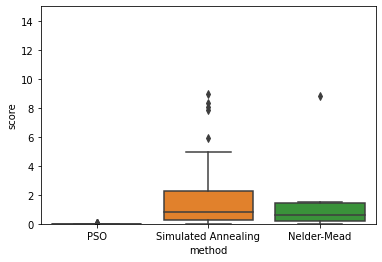

In [11]:
metrics = []
for i in range(50):
    lbs = np.array(np.ones(2)*-3)
    ubs = np.array(np.ones(2)*4)
    
    model1 = PSO()
    p1,f1 = model1.optimize(rosenbrock_1,lbs,ubs)
    metrics.append({"score":f1,"method":"PSO"})
    
    model2 = SimulatedAnnealing()
    starting_point = np.random.uniform(-3,4,size = 2)
    p2,f2 = model2.optimize(rosenbrock_1,starting_point)
    metrics.append({"score":f2,"method":"Simulated Annealing"})
    
    model3 = NelderMead(30)
    p3,f3 = model3.optimize(rosenbrock_1,lbs,ubs)
    if f3 < 0:print(p3)
    metrics.append({"score":f3,"method":"Nelder-Mead"})
    
metrics = pd.DataFrame.from_dict(metrics)
box=sns.boxplot("method","score",data= metrics)
box = box.set(ylim=(0,15))

In [12]:
metrics.groupby("method").describe()

score                                                   \
                    count        mean          std           min       25%   
method                                                                       
Nelder-Mead          50.0  580.295401  2152.283721  1.958569e-06  0.211417   
PSO                  50.0    0.008716     0.018399  3.821370e-08  0.000016   
Simulated Annealing  50.0    6.125508    21.839757  1.185354e-04  0.248733   

                                                       
                          50%       75%           max  
method                                                 
Nelder-Mead          0.598955  1.440231  12689.589676  
PSO                  0.000882  0.006063      0.082256  
Simulated Annealing  0.787711  2.286543    112.290282

As can be seen from the box-plot above, Simulated Annealing performs the worst followed by Nelder Mead and then PSO. This is largely because using the base hyperparameters of PSO, there are 50 particles exploring the search space while only 3 and 1 respectively for Nelder-Mead and Simulated Annealing. The greater number of particles exploring the search space also reduces the variance in performance results as can be seen from the very low standard deviation of the PSO method. Nelder-Mead while having 3 search points relies on extrapolating the behavior of the function. The Rosenbrock function increases drastically when it is far from the origin and due to this, certain initializations of the Nelder-Mead method can lead to very poor solutions.

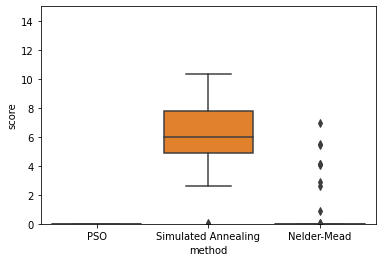

In [13]:
metrics = []
for i in range(50):
    lbs = np.array(np.ones(2)*-3)
    ubs = np.array(np.ones(2)*4)
    
    model1 = PSO()
    p1,f1 = model1.optimize(ackley,lbs,ubs)
    metrics.append({"score":f1,"method":"PSO"})
    
    model2 = SimulatedAnnealing()
    starting_point = np.random.uniform(-3,4,size = 2)
    p2,f2 = model2.optimize(ackley,starting_point)
    metrics.append({"score":f2,"method":"Simulated Annealing"})
    
    model3 = NelderMead(30)
    p3,f3 = model3.optimize(ackley,lbs,ubs)
    metrics.append({"score":f3,"method":"Nelder-Mead"})
    
metrics = pd.DataFrame.from_dict(metrics)
box=sns.boxplot("method","score",data= metrics)
box = box.set(ylim=(0,15))

In [14]:
metrics.groupby("method").describe()

score                                                    \
                    count      mean       std       min       25%       50%   
method                                                                        
Nelder-Mead          50.0  0.737875  1.737609  0.000279  0.002003  0.005394   
PSO                  50.0  0.000575  0.000221  0.000164  0.000420  0.000546   
Simulated Annealing  50.0  6.035755  2.302273  0.005810  4.905926  5.999832   

                                          
                          75%        max  
method                                    
Nelder-Mead          0.012196   6.981706  
PSO                  0.000748   0.001154  
Simulated Annealing  7.799742  10.344204

Due to the function not having extremely steep contours, the performance of the Nelder-Mead method improves dramatically. The difference in box plots also illustrates the key weakness of Simulated Annealing which is the fact that Simulated Annealing tends to get stuck in local minimas.The vast majority of particles get stuck in the local minima scattered around the search space which results in a higher function value.

### Computational Time
Besides accuracy, another important concern when performing optimisation is the computational time required to perform the algorithm. One simple, way to evaluate this is to measure the amount of time required for $n$ iterations of the algorithm.

Text(0.5, 1.0, 'Time taken for optimization algorithms')

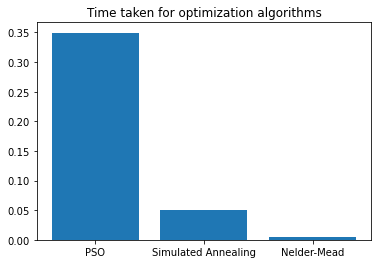

In [15]:
import time
timer =dict()

start = time.time()
lbs = np.array(np.ones(2)*-3)
ubs = np.array(np.ones(2)*4)

model1 = PSO()
p1,f1 = model1.optimize(ackley,lbs,ubs)
end = time.time() 
timer["PSO"] = end - start

start = time.time()
model2 = SimulatedAnnealing()
starting_point = np.random.uniform(-3,4,size = 2)
p2,f2 = model2.optimize(ackley,starting_point)
end = time.time()
timer["Simulated Annealing"] = end - start

start = time.time()
model3 = NelderMead(30)
p3,f3 = model3.optimize(ackley,lbs,ubs)
end = time.time()
timer["Nelder-Mead"] = end - start

plt.bar(np.arange(3),timer.values(),tick_label = list(timer.keys()))
plt.title("Time taken for optimization algorithms")

As expected, PSO performs the worst and takes signficantly more time to execute than the other algorithms. While Simulated Annealing only has one particle to simulate at each time step, it has to execute for significantly more iterations for the algorithm to be useful.

One important note is that the PSO algorithm can be parallized more effectively that the current implementation. If the position and velocity vectors are stored in an array, the new velocity matrix can be calculated using matrix operations and the updating of the position vector will also be a simple matrix calculation. Matrix multiplications can be easily parallelized which will greatly speed up the computation time required.

## Application of no-grad optimisation methods

### Non-differentiable Loss Functions
The biggest strength of no-grad optimisation methods is that they are able to work on functions which are not smooth. If non-linear functions are used on the original loss function like $\max$, $\min$, L1-Norm, the resulting function can be non-smooth. This may lead to the use of sub-gradient methods or the optimisation process might also fail entirely. In other optimisation problem such as in combinatorics (Travelling Salesman Problem) or discrete problems (Integer Programming), it might be completely impossible to derive smooth loss functions for optimisation. In such scenarios, no-gradient based optimisation methods may achieve some success. 

### Hyperparameter Optimisation
Another common application for no-gradient methods in machine learning is for hyperparameter optimisation. In most machine learning applications, the end goal is to optimize a metric on a validation set which shows the ability of the machine learning to generalise to unseen data. In most machine learning models, some of the hyperparameters are discrete integers (eg. maximum depth of tree for random forests) which are not differentiable preventing the use of gradient-based optimization. For each set of hyperparameters to be tested, the model will be initialised with that particular set of hyperparameters and the model performance will be the function value at the point. 

One disadvantage of all these methods is that they assume deterministic function behavior. For hyperparameter optimisation, certain algorithms like Random Forest and XGBoost and randomly initialised and given the same set of hyperparameters, the resulting performance of the model can be different. All of these methods do not take into account the stochastic behavior of hyperparameter optimisation and can result in poor performance.

As a result, probabilistic methods like Bayesian optimisation are more commonly used for hyperparameter optimisation. Instead of optimising a deterministic function, Bayesian optimisation aims to optimise a probability distribution where the outcome is the performance of the model. This allows it to be more robust towards machine learning methods which have stochastic behavior.


### Limitations

The most significant limitation of the optimization methods is that they are not scalable to high dimension datasets. As the number of dimensions increases, the search space increases exponentially and the amount of space that the algorithm can explore diminishes. This problem is known as the "curse of dimensionality" [4] and is a significant issue for optimisation in high-dimensional datasets. Gradients and Hessians provide local information about the topology of the function to be optimized but since this information cannot be used in no-grad methods, the algorithms will have to spend a greater amount of time exploring the search space. 

Using PSO as an example, one way to visualise this problem is by modelling each particle as a unit ball. This unit ball is an approximation for the space which the particle explores when using the PSO algorithm. By comparing the volume of the search space with the total volume of all particles, the proportion of space explored can be estimated. The volume of a unit ball in n-dimension can be calculated using the formula below.

$$
V = \frac{\pi^{\frac{1}{2}n}r^n}{\Gamma(\frac{1}{2}n+1)}
$$


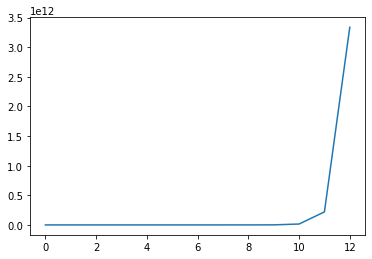

In [16]:
# Generating Volume Comparison Graph
# Search Space will be defined as being a hypercube from -5 to +5 for easier computation
# Volume of Unit ball
from scipy.special import gamma
ratios = []
for n in range(2,15):
    cube = 10**n
    ball = math.pi**(n/2)/gamma(n/2+1)
    ratios.append(cube/(ball*50))
plt.plot(ratios)

As can be seen from the graph below, the volume ratio increases exponentially as the number of dimensions increase. Another way of visualising this problem is to calculate the computational time to achieve an .This can be done using the n-dimensional formulation of the Rosenbrock function which always has a global optima at $\mathbb{1}^n$. For this both the Nelder Mead method and Particle Swarm Optimisation are used to observe the robustness of each algorithm to increase in dimensionality.

In [17]:
dim_range = range(2,33,2)
dim_df = {str(i):[] for i in dim_range}
for dim in dim_range:
    for i in range(25):
        lbs = np.array(np.ones(dim)*-5)
        ubs = np.array(np.ones(dim)*6)
        model1 = NelderMead(30)
        p1,f1 = model1.optimize(ackley,lbs,ubs)
        dim_df[str(dim)].append(f1)
dim_df = pd.DataFrame(dim_df)

dim_range = range(2,33,2)
dim_df2 = {str(i):[] for i in dim_range}
for dim in dim_range:
    for i in range(25):
        lbs = np.array(np.ones(dim)*-5)
        ubs = np.array(np.ones(dim)*6)
        model1 = PSO(n_iter = 15)
        p1,f1 = model1.optimize(ackley,lbs,ubs)
        dim_df2[str(dim)].append(f1)
dim_df2 = pd.DataFrame(dim_df2)

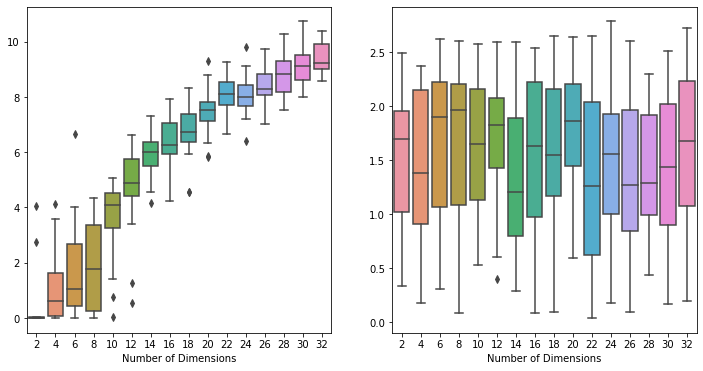

In [18]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.boxplot(data = dim_df,ax = ax[0])
sns.boxplot(data = dim_df2,ax = ax[1])
ax[0].set_xlabel("Number of Dimensions")
ax[1].set_xlabel("Number of Dimensions")
plt.show()

As can be seen from the boxplots accuracy decreases as number of dimensions increases. This is clearly more pronounced for the Nelder Mead method compared to the PSO algorithm which more robust to increase in dimensionality. However an important caveat when looking at the boxplots is that the Rosenbrock function has very sharp curvature and is relatively simple to optimise. For real world applications, the topology of the loss functions can contain more local minima and in those cases the decrease in performance will be more pronounced as dimension increases.

Besides the decrease in accuracy, distance computations for PSO and Nelder-Mead will take more computational time which further reduces its efficiency. This reduction in computational speed will also affect Simulated Annealing where the time required to obtain neighbours and their positions will increase exponentially with dimensions

## Conclusion

Understanding no-gradient optimisation methods is important because not all problems today have differentiable loss functions. These three different methods all take very unique and intelligent approaches towards optimising functions despite lacking gradient information. Each one of these algorithms have different advantages and disadvantages and none of them is definitely superior regardless of application. This is consistent with the "No free lunch theory in optimisation" which states that the **computational cost** to arrive at a solution will be the same when averaged across all problems[5]. As such it is important for us as data scientists to be exposed to different algorithms and understand how they function. This provides us with a greater variety of optimisation methods experiment with so as to pick the method which is most optimum for the specific problem.

## References
(1)  - Kennedy, J.; Eberhart, R. (1995). "Particle Swarm Optimization". Proceedings of IEEE International Conference on Neural Networks. IV. pp. 1942–1948

(2) -  Pincus, Martin (Nov–Dec 1970). "A Monte-Carlo Method for the Approximate Solution of Certain Types of Constrained Optimization Problems". Journal of the Operations Research Society of America. 18 (6): 967–1235. doi:10.1287/opre.18.6.1225 

(3) - J. A. Nelder, R. Mead, A Simplex Method for Function Minimization, The Computer Journal, Volume 7, Issue 4, January 1965, Pages 308–313, https://doi.org/10.1093/comjnl/7.4.308

(4) - Marimont, R.B.; Shapiro, M.B. (1979). "Nearest Neighbour Searches and the Curse of Dimensionality". IMA J Appl Math. 24 (1): 59–70. doi:10.1093/imamat/24.1.59.

(5) - Wolpert, D. H.; Macready, W. G. (1997). "No Free Lunch Theorems for Optimization" (PDF). IEEE Transactions on Evolutionary Computation. 1: 67.